In [1]:
import cv2
import torch
import numpy as np
import albumentations as A
import torch.optim as optim
import torch.utils.data as dt
import matplotlib.pyplot as plt
import torchvision.transforms as tf
import segmentation_models_pytorch as smp

from tqdm import tqdm
from imutils import paths
from torchmetrics import Dice
from sklearn.model_selection import train_test_split

epoch = 1
data_path = "DATASET/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
memory = True if device == 'cuda' else False

In [2]:
def image_resize(img, size_x = 224, size_y = 224):
    height = img.shape[0]
    width = img.shape[1]
    problem = abs(height - width)
    sz = [int(problem / 2), problem - int(problem / 2), 0]
    if width >= height:
        img = cv2.copyMakeBorder(
            img, sz[0], sz[1], sz[2], sz[2], cv2.BORDER_CONSTANT)
    else:
        img = cv2.copyMakeBorder(
            img, sz[2], sz[2], sz[0], sz[1], cv2.BORDER_CONSTANT)
    img = cv2.resize(img, (size_x, size_y))
    return img

In [3]:
class SegmentationDataset(dt.Dataset):
    def __init__(self, imagPaths, maskPaths, transforms, transforms_affine=None):
        self.imagPaths = imagPaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.transforms_affine = transforms_affine

    def __len__(self):
        return len(self.imagPaths)

    def __getitem__(self, idx):
        imag = cv2.imread(self.imagPaths[idx], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)
        imag = image_resize(imag)
        mask = image_resize(mask)
        if self.transforms_affine != None:
            transformed = self.transforms_affine(image=imag, mask=mask)
            imag = transformed["image"]
            mask = transformed["mask"]
        imag = self.transforms(imag)
        mask = tf.Compose([tf.ToTensor()])(mask)
        return imag, mask

In [4]:
class SegmentationTestDataset(dt.Dataset):
    def __init__(self, imagPaths, maskPaths, transforms):
        self.imagPaths = imagPaths
        self.maskPaths = maskPaths
        self.transforms = transforms

    def __len__(self):
        return len(self.imagPaths)

    def __getitem__(self, idx):
        imag = cv2.imread(self.imagPaths[idx], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)
        imag = image_resize(imag)
        mask = image_resize(mask)
        real = tf.Compose([tf.ToTensor()])(imag)
        mask = tf.Compose([tf.ToTensor()])(mask)
        imag = self.transforms(imag)
        return real, imag, mask

In [5]:
def get_data(imag_path, mask_path):
    all_path_imag = sorted(list(paths.list_images(imag_path)))
    all_path_mask = sorted(list(paths.list_images(mask_path)))
    split = train_test_split(all_path_imag, all_path_mask, test_size=0.2)
    (train_imag, test_imag) = split[:2]
    (train_mask, test_mask) = split[2:]
    return train_imag, test_imag, train_mask, test_mask

In [6]:
def get_mean_std(train_imag, train_mask, batch_size):
    transform_none = tf.Compose([tf.ToTensor()])
    imag_train = SegmentationDataset(train_imag, train_mask, transform_none)
    train_loader = dt.DataLoader(imag_train, batch_size=batch_size, shuffle=True)
    mean = torch.tensor([0., 0., 0.])
    std = torch.tensor([0., 0., 0.])
    for data in train_loader:
        img, mask = data
        mean += img.mean([0, 2, 3])
        std += img.std([0, 2, 3])
    mean /= len(train_loader)
    std /= len(train_loader)
    return mean, std

In [7]:
def get_dataset(train_imag, test_imag, train_mask, test_mask, batch_size, transform = tf.Compose([tf.ToTensor()]), transform_affine = A.Compose([A.HorizontalFlip(p=0)]), concat = None):
    imag_train_trans = SegmentationDataset(train_imag, train_mask, transform, transform_affine)
    imag_test_trans = SegmentationDataset(test_imag, test_mask, transform, transform_affine)
    if concat:
        imag_train = SegmentationDataset(train_imag, train_mask, transform)
        imag_test = SegmentationDataset(test_imag, test_mask, transform)
        imag_train_trans = dt.ConcatDataset([imag_train, imag_train_trans])
        imag_test_trans = dt.ConcatDataset([imag_test, imag_test_trans])
    dataset_train = dt.DataLoader(imag_train_trans, batch_size=batch_size, shuffle=True)
    dataset_test = dt.DataLoader(imag_test_trans, batch_size=batch_size, shuffle=False)
    return dataset_train, dataset_test

In [8]:
bad_batch_size = 4
bad_path_imag = data_path + "gen_smoke_bad"
bad_path_mask = data_path + "gen_smoke_bad_masks"
bad_train_imag, bad_test_imag, bad_train_mask, bad_test_mask = get_data(bad_path_imag, bad_path_mask)
bad_mean, bad_std = get_mean_std(bad_train_imag, bad_train_mask, bad_batch_size)
bad_transform = tf.Compose([tf.ToTensor(), tf.Normalize(bad_mean, bad_std),
                            tf.GaussianBlur(kernel_size=(7, 13), sigma=(0.25, 0.5))])
bad_dataset_train, bad_dataset_test = get_dataset(bad_train_imag, bad_test_imag,
                                                  bad_train_mask, bad_test_mask,
                                                  bad_batch_size, bad_transform)

blender_batch_size = 4
blender_path_imag = data_path + "blender_smoke"
blender_path_mask = data_path + "blender_smoke_masks"
blender_train_imag, blender_test_imag, blender_train_mask, blender_test_mask = get_data(blender_path_imag, blender_path_mask)
blender_mean, blender_std = get_mean_std(blender_train_imag, blender_train_mask, blender_batch_size)
blender_transform = tf.Compose([tf.ToTensor(), tf.Normalize(blender_mean, blender_std),
                                tf.GaussianBlur(kernel_size=(7, 13), sigma=(0.25, 0.5))])
blender_transform_affine = A.Compose([A.Perspective(scale=(0.05, 0.2), p=1.),
                                      A.Affine(rotate=25, scale=(1, 1)),
                                      A.HorizontalFlip(p=.5),
                                      A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1)])
blender_dataset_train, blender_dataset_test = get_dataset(blender_train_imag, blender_test_imag,
                                                          blender_train_mask, blender_test_mask,
                                                          blender_batch_size, blender_transform,
                                                          blender_transform_affine, True)

good_batch_size = 4
good_path_imag = data_path + "orig_smoke"
good_path_mask = data_path + "orig_smoke_masks"
good_train_imag, good_test_imag, good_train_mask, good_test_mask = get_data(good_path_imag, good_path_mask)
good_mean, good_std = get_mean_std(good_train_imag, good_train_mask, good_batch_size)
good_transform = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
good_transform_affine = A.Compose([A.Perspective(scale=(0.05, 0.3), p=1.),
                                   A.Affine(rotate=25, scale=(0.9, 0.9)),
                                   A.HorizontalFlip(p=.5)])
good_dataset_train, good_dataset_test = get_dataset(good_train_imag, good_test_imag,
                                                    good_train_mask, good_test_mask,
                                                    good_batch_size, good_transform,
                                                    good_transform_affine, True)

test_batch_size = 1
test_Paths = sorted(list(paths.list_images(data_path + 'test')))
test_masks_Path = sorted(list(paths.list_images(data_path + 'test_mask')))
test_transform = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
test_imag = SegmentationTestDataset(test_Paths, test_masks_Path, test_transform)
test_dataset = dt.DataLoader(test_imag, batch_size=test_batch_size, shuffle=False)

In [9]:
def draw_plot(H):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 10))
    plt.plot(np.arange(1, len(H["loss"])+1), H["loss"], label="loss")
    plt.plot(np.arange(1, len(H["accu"])+1), H["accu"], label="accu")
    plt.title("Training Loss and Accu")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

In [10]:
model = smp.MAnet(
    encoder_name="efficientnet-b7",
    encoder_depth=5,
    encoder_weights='imagenet',
    activation='sigmoid'
).to(device)

loss_func = torch.nn.BCELoss().to(device)
accu_func = Dice().to(device)

In [11]:
def train(train_loader, test_loader, learning_rate=1e-4, num_epoch=5, scheduler=5):
    global epoch, model, H
    best_epoch = 0
    best_epoch_ind = 0
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    for e in range(num_epoch):
        model.train()
        totalLoss = 0
        totalAccu = 0
        if (e + 1) % scheduler == 0:
            learning_rate /= scheduler
        for (i, (x, y)) in tqdm(enumerate(train_loader), total=len(train_loader)):
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = loss_func(pred.squeeze(1), y.squeeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            totalLoss += loss
        with torch.no_grad():
            model.eval()
            for (x, y) in test_loader:
                (x, y) = (x.to(device), y.to(device))
                pred = model(x)
                accu = accu_func(pred.squeeze(1), y.squeeze(1) > 0.5)
                totalAccu += accu

        avgLoss = totalLoss / len(train_loader)
        avgAccu = totalAccu / len(test_loader)
        H["loss"].append(avgLoss.cpu().detach().numpy())
        H["accu"].append(avgAccu.cpu().detach().numpy())
        print("[INFO] EPOCH: {}".format(epoch))
        print("loss: {:.4f}, accu: {:.4f}\n".format(avgLoss, avgAccu))

        if best_epoch < avgAccu:
            best_epoch = avgAccu
            best_epoch_ind = epoch
        torch.save(model.state_dict(),
                   "EPOCH/model_weights-" + str(epoch) + ".pth")
        epoch += 1
    model.load_state_dict(torch.load("EPOCH/model_weights-" +
                          str(best_epoch_ind) + ".pth", map_location=torch.device(device)))

In [ ]:
H = {"loss": [], "accu": []}
train(bad_dataset_train, bad_dataset_test, num_epoch=5)
draw_plot(H)

In [12]:
model.load_state_dict(torch.load("good.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
H = {"loss": [], "accu": []}
train(blender_dataset_train, blender_dataset_test, num_epoch=10)
draw_plot(H)

100%|██████████| 285/285 [01:54<00:00,  2.49it/s]


[INFO] EPOCH: 1
loss: 0.1079, accu: 0.8671



100%|██████████| 285/285 [01:37<00:00,  2.92it/s]


[INFO] EPOCH: 2
loss: 0.1069, accu: 0.8656



100%|██████████| 285/285 [01:37<00:00,  2.93it/s]


[INFO] EPOCH: 3
loss: 0.0987, accu: 0.8693



100%|██████████| 285/285 [01:37<00:00,  2.93it/s]


[INFO] EPOCH: 4
loss: 0.1025, accu: 0.8667



100%|██████████| 285/285 [01:37<00:00,  2.92it/s]


[INFO] EPOCH: 5
loss: 0.0988, accu: 0.8517



100%|██████████| 285/285 [01:37<00:00,  2.91it/s]


[INFO] EPOCH: 6
loss: 0.0944, accu: 0.8720



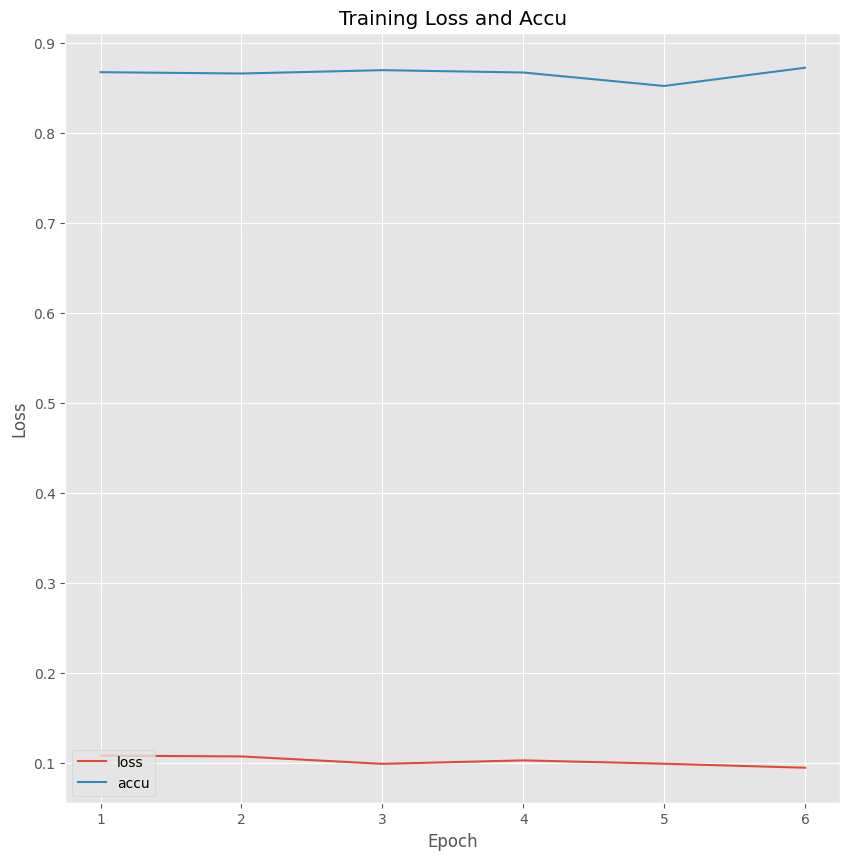

In [13]:
H = {"loss": [], "accu": []}
train(good_dataset_train, good_dataset_test, num_epoch=6)
draw_plot(H)

AVG accu: 0.8377


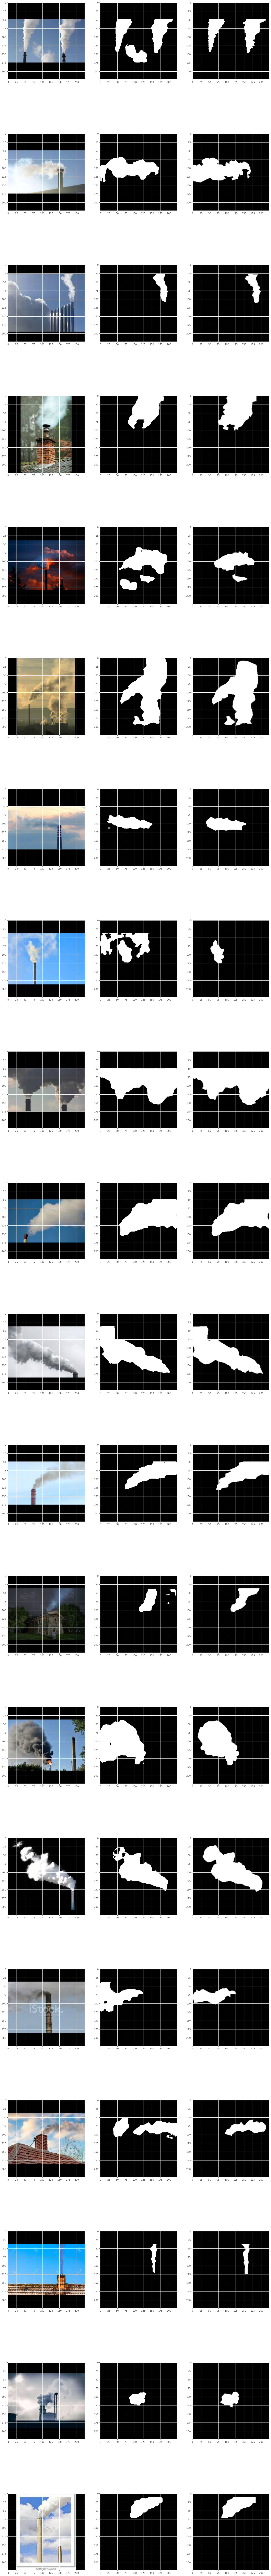

In [15]:
totalAccu = 0
fig, ax = plt.subplots(20, 3, figsize=(20, 200))
with torch.no_grad():
    model.eval()
    for (i, (r, x, y)) in enumerate(test_dataset):
        (r, x, y) = (r.to(device), x.to(device), y.to(device))
        p = model(x)
        if i < 20:
            ax[i][0].imshow(cv2.cvtColor(np.clip(
                r.squeeze(0).cpu().numpy().transpose(1, 2, 0), 0, 1), cv2.COLOR_RGB2BGR))
            ax[i][1].imshow(cv2.cvtColor(p.squeeze(0).cpu().numpy(
            ).round().transpose(1, 2, 0), cv2.IMREAD_GRAYSCALE))
            ax[i][2].imshow(cv2.cvtColor(
                y.squeeze(0).cpu().numpy().transpose(1, 2, 0), cv2.IMREAD_GRAYSCALE))
        totalAccu += accu_func(p.squeeze(1), y.squeeze(1) > 0.5)
avgAccu = totalAccu / len(test_dataset)
print("AVG accu: {:.4f}".format(avgAccu))

In [16]:
torch.save(model.state_dict(), "MegaHarosh.pth")

In [ ]:
def write_video(file_path, frames, fps):
    num, w, h, ch = frames.shape
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write(np.uint8(frame))

    writer.release()

In [ ]:
def check_dist(prev_p, p, r=10):
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            if(prev_p[max(0,i-r):min(p.shape[0], i + r),max(0,j-r):min(p.shape[1], j + r)].sum() == 0):
                p[i,j] = 0
    return p

In [ ]:
def read_video(file_path, skip=10):
    global model
    video = cv2.VideoCapture(file_path)
    transforms = tf.Compose([tf.ToTensor(), tf.Normalize(good_mean, good_std)])
    images = []
    num_frame = 0
    prev_p = np.nan
    with torch.no_grad():
        model.eval()
        while (video.isOpened()):
            num_frame += 1
            flag, x = video.read()
            if flag:
                img_cpy = np.copy(x)
                img_cpy = image_resize(img_cpy, max(img_cpy.shape[1],img_cpy.shape[0]),
                                                max(img_cpy.shape[1],img_cpy.shape[0]))
                img_cpy = cv2.normalize(img_cpy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U)
                
                x = image_resize(x)
                p = model(transforms(x).to(device).unsqueeze(0))
                p = p.cpu().numpy().squeeze()
                x = cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U)
                p = np.expand_dims(cv2.normalize(
                    p.round(), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_16U), axis=2)

                if num_frame > skip:
                    p = check_dist(prev_p, p)
                    prev_p = p
                elif num_frame < skip:
                    if (num_frame == 1):
                        prev_p = p
                    else:
                        prev_p += p
                else:
                    prev_p += prev_p
                    prev_p //= skip

                p = image_resize(p, max(img_cpy.shape[1],img_cpy.shape[0]),
                                    max(img_cpy.shape[1],img_cpy.shape[0]))
                p = np.expand_dims(cv2.blur(p, (13, 7)), axis=2)
                
                img_cpy[:, :, 1] = np.where(
                    p[:, :, 0] < 128, img_cpy[:, :, 1], img_cpy[:, :, 1] * 0.7)
                img_cpy[:, :, 0] = np.where(
                    p[:, :, 0] < 128, img_cpy[:, :, 0], img_cpy[:, :, 0] * 0.7)
                img_cpy[:, :, 2] = np.where(
                    p[:, :, 0] < 128, img_cpy[:, :, 2], img_cpy[:, :, 2] * 0.7 + p[:, :, 0] * 0.3)
                images.append(img_cpy)

                if (num_frame == 300):
                    break
            else:
                break
    video.release()
    return np.array(images)

In [ ]:
images = read_video('DATASET/video/6.mp4')
write_video('vidMOD.avi', images, 30)